In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import numpy as np

In [2]:
data = pd.read_csv("Auction_master_train.csv")
data.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,...,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,...,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,...,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,...,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,...,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


In [3]:
data.shape

(1933, 41)

## 1. 데이터 전처리

### 1) NA값 처리

In [4]:
data.isna().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_li                        1910
addr_san                          0
addr_bunji1                       4
addr_bunji2                    1044
addr_etc                          0
Apartment_usage             

In [5]:
data = data.drop(['addr_li','addr_bunji2','Specific','road_bunji2'],axis=1)

- road_bunji1(NA IMPUTATION)

### 2) 날짜 관련 변수

- 최초 경매일, 최종 경매일

In [6]:
from datetime import datetime
data['First_auction_date'] = data['First_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))
data['Final_auction_date'] = data['Final_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))

In [7]:
data['Final-First_auction_data'] = data['Final_auction_date']-data['First_auction_date'] #최종경매일, 최초경매일 일수 차이
data['Final-First_auction_data'] = data['Final-First_auction_data'].astype('timedelta64[D]').astype(int)

In [8]:
data = data.drop(['Final_auction_date','First_auction_date','Appraisal_date'],axis=1) #감정일자는 중요한 변수가 아닌 것 같아서 drop

### 3) 이상치제거

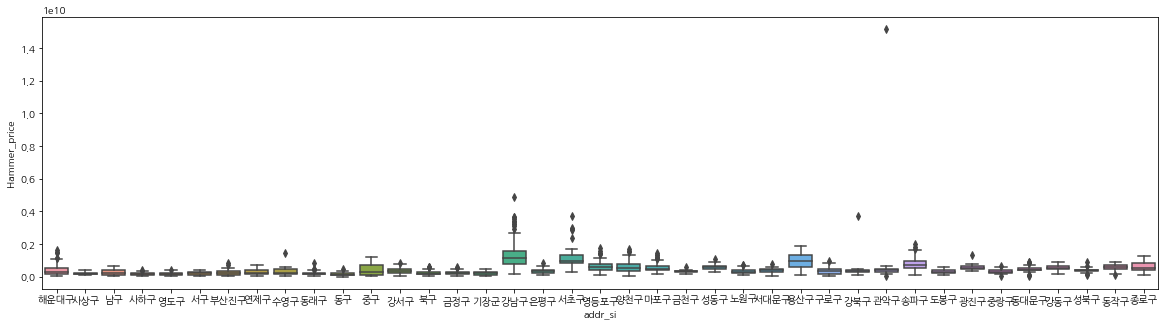

In [9]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)

sns.boxplot(x='addr_si',y='Hammer_price',data=data)

In [10]:
def outlier(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lb = q1 - (iqr*1.5)
    ub = q3 + (iqr*1.5)
    
    return np.where((data>ub)|(data<lb))

In [11]:
tmp = data['addr_si'].unique()
data = data.reset_index()

In [12]:
d = []
for i in tmp:
    ind = outlier(data[data['addr_si']==i]['Hammer_price'])
    ind2 = list(data[data['addr_si']==i].iloc[ind[0],:]['index'])
    if len(ind2) != 0 :
        d = d+ind2

In [13]:
data = data.drop(index=d)

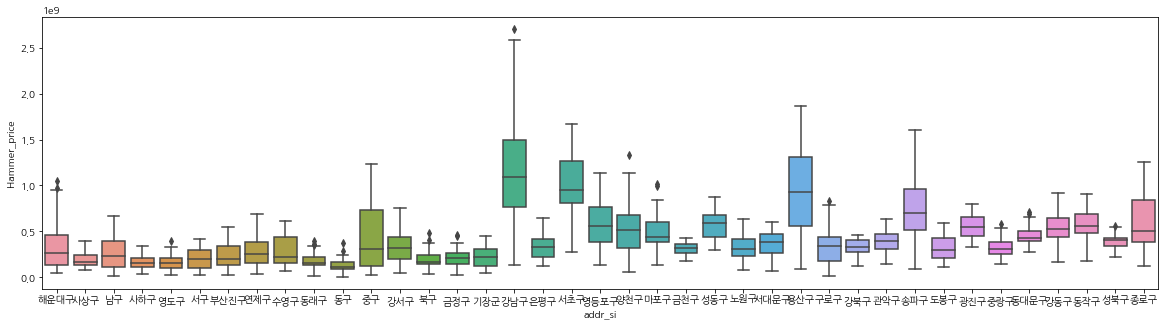

In [14]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)

sns.boxplot(x='addr_si',y='Hammer_price',data=data)

- 클러스터링해서 그룹마다 모델링? 모델마다 다른 변수 selection을 할 게 아니면 의미가 없어보임
- 시군구 별로 one-hot encoding하는 방식 column이 너무 많아진다
- 각 시군구의 y값에 대한 min q1 q2 q3 max 값을 기준으로 clustering 해서 새롭게 카테고리 생성하자

In [15]:
data = data.drop(['index'],axis=1)

In [16]:
def get_quantile(data):
    q1, q2, q3 = np.percentile(data,[25,50,75])
    return [min(data),q1,q2,q3,max(data)]

In [17]:
df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['addr_si']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

In [18]:
df['addr_si'] = tmp

In [19]:
df.head()

,min,q1,q2,q3,max,addr_si
0,41000000.0,127531630.0,258195000.0,458217252.5,1.050000e+09,해운대구
1,72220000.0,133355000.0,162790055.0,244747750.0,3.975000e+08,사상구
2,12760000.0,114012500.0,224556099.5,397950000.0,6.671200e+08,남구
3,31888000.0,109650492.5,151500000.0,204894250.0,3.427500e+08,사하구
4,22000000.0,103387000.0,153650550.0,210496050.0,3.940000e+08,영도구


In [20]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

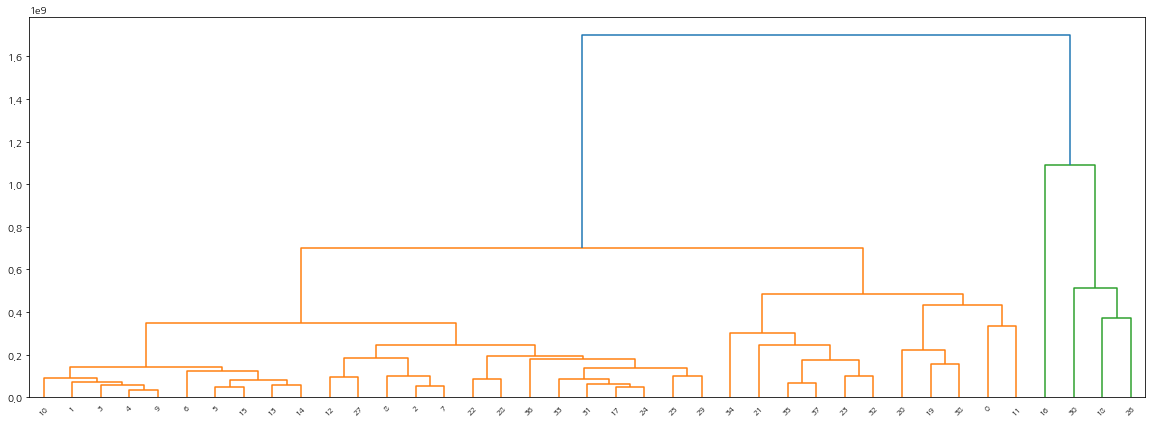

In [21]:
plt.figure(figsize=(20,7))
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
dent = shc.dendrogram(shc.linkage(df.iloc[:,:-1],method='average'))

- 클러스터 간 모든 점 사이 거리의 평균값 사용

In [22]:
c1 = df.iloc[[34,21,35,36,23,32,20,19,33,0,11],:]['addr_si']
c2 = df.iloc[[16,18,30,26],:]['addr_si']
c3 = df.iloc[[10,1,3,4,9,6,5,15,13,14],:]['addr_si']
c4 = df.iloc[[12,27,8,2,7,22,28,37,38,31,17,24,25,29]]['addr_si'] 

## 2. Feature selecting + Y값 변환

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


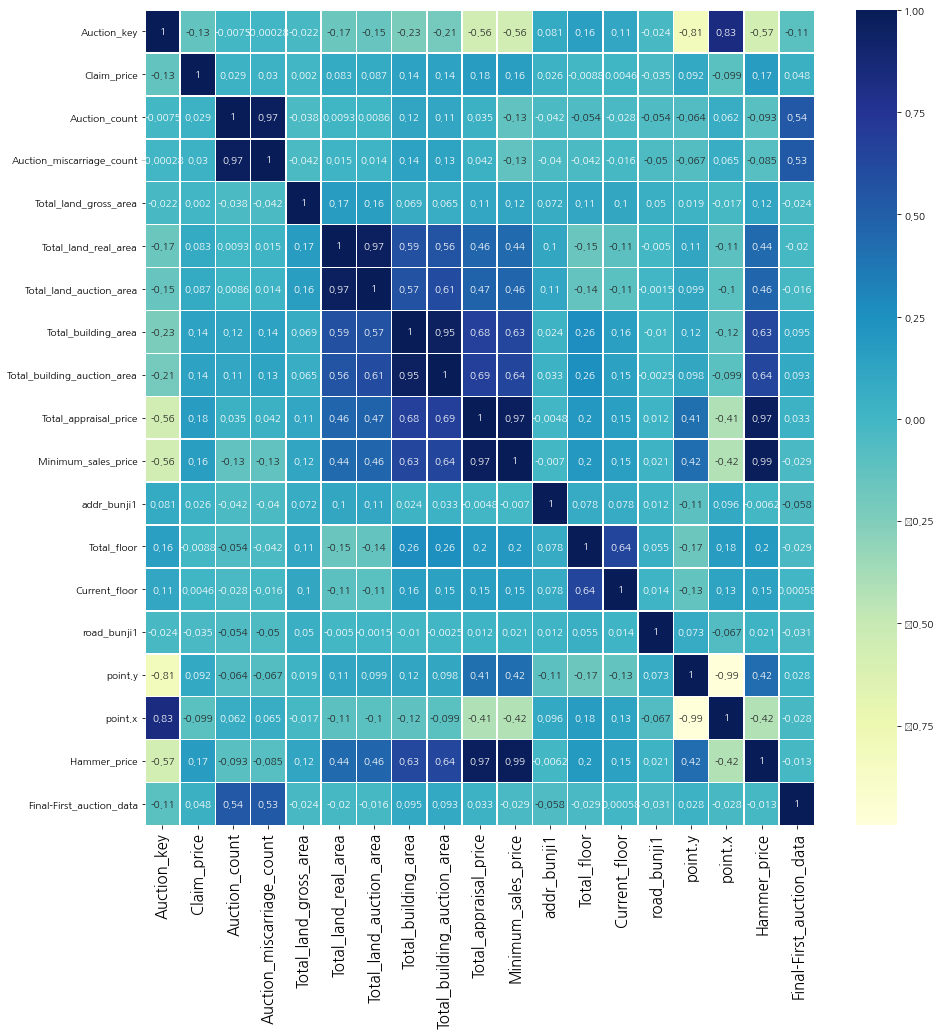

In [24]:
figure,ax1 = plt.subplots()
figure.set_size_inches(15,15)
sns.heatmap(data.corr(),linewidths=0.5,annot=True,cmap='YlGnBu')

In [25]:
data.corr()['Hammer_price']

Auction_key                   -0.567600
Claim_price                    0.171794
Auction_count                 -0.092586
Auction_miscarriage_count     -0.085099
Total_land_gross_area          0.116462
Total_land_real_area           0.442568
Total_land_auction_area        0.457792
Total_building_area            0.628985
Total_building_auction_area    0.637609
Total_appraisal_price          0.974735
Minimum_sales_price            0.989284
addr_bunji1                   -0.006176
Total_floor                    0.196538
Current_floor                  0.146635
road_bunji1                    0.020693
point.y                        0.424779
point.x                       -0.423866
Hammer_price                   1.000000
Final-First_auction_data      -0.013486
Name: Hammer_price, dtype: float64

- 최저매각가격(입찰 시 입찰인이 최저로 제시해야 하는 금액) 변수와 y변수인 Hammer_price의 상관관계가 0.99
- y값 자체를 hammer_price/Minimum_sales_price 로 변환하자
- Total_appraisal_price 총감정가 변수 제거

In [26]:
data['new_y'] = data['Hammer_price']/data['Minimum_sales_price']

In [27]:
data = data.drop(['Minimum_sales_price','Total_appraisal_price'],axis=1)

면적 관련 변수들의 correlation을 살펴보자

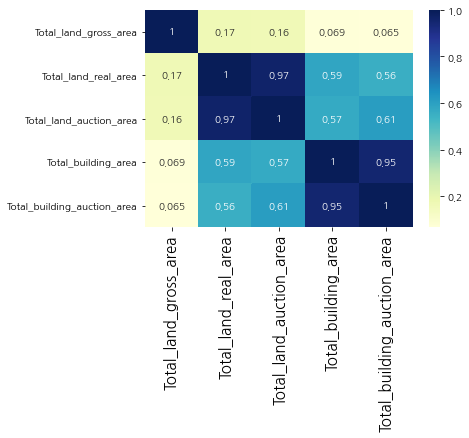

In [28]:
sns.heatmap(data.iloc[:,7:12].corr(),annot=True,cmap='YlGnBu')

- total_land_gross_area(총토지전체면적), total_building_auction_area(총건물경매면적)만 사용

In [29]:
data = data.drop(['Total_land_real_area','Total_land_auction_area','Total_building_area'],axis=1)